In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from helper import country_count, butterflies, caterpillars

In [35]:
name = "Green_Bonds"
data = pd.read_csv("input/policy/" + name + ".csv", index_col=0, keep_default_na=False, na_values="")
data = data[np.logical_not(data["ISO2"].isna())] #filter down

In [24]:
years = [year for year in data.columns if len(year) == 5 and year[0] == 'F']

#create temporal
reindexed = data.set_index(["ISO2", "CTS_Code"], inplace = False)
temporal = {}
year = "F2020"
edge_list = []
country = "AF"
subset = reindexed.loc[country]
policy = "GENB_G14"
weight = subset.loc[policy][year] #edge weights are bond values

In [ ]:
if weight > 0:
    edge = (country, policy, weight) #create edge
    edge_list.append(edge)
temporal[int(year[1:])] = edge_list

### Green Bonds

##### Intro

In [2]:
green_bonds = pd.read_csv("input/policy/Green_Bonds.csv", index_col=0, keep_default_na=False, na_values="")

# Filtered Down to countries
green_bonds = green_bonds[np.logical_not(green_bonds["ISO2"].isna())]

green_bond_country_nodes = green_bonds.ISO2.unique()

# Need to figure out the differences between these bonds
bonds_nodes = green_bonds["CTS_Name"].unique()

Looks likes most years no one invested in bonds. Still very few countries invest in bonds but each year it seems the number increases.

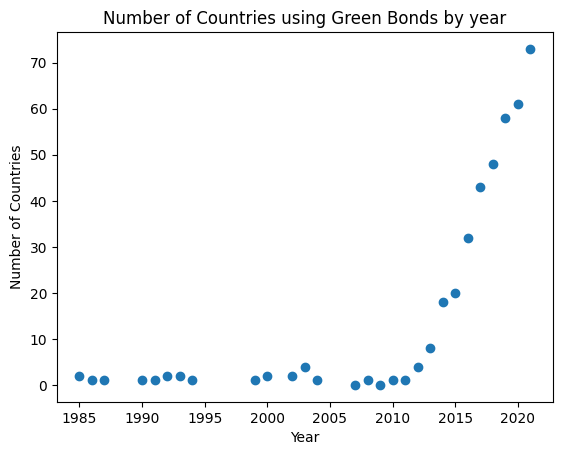

In [3]:
# Get the data
num_countries = green_bonds[green_bonds.columns[12:]].count().to_list()
years = [int(year[1:]) for year in green_bonds.columns[12:]]

# Plot
fig,ax = plt.subplots()
ax.scatter(years, num_countries)
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")

plt.show()

Furthermore we can break the graph down into its two different categories

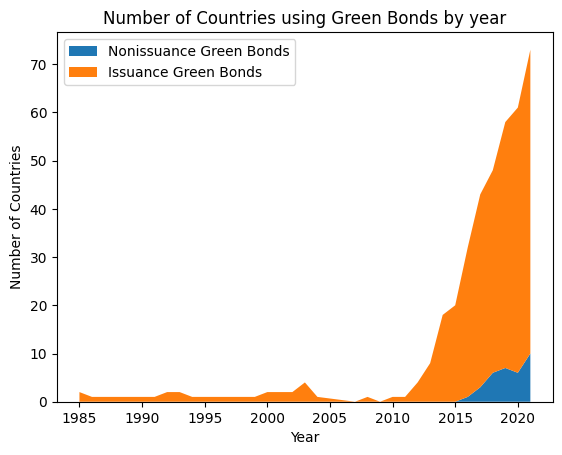

In [4]:
# Get the data
issuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds Issuances"]

# Calculate Variables
issuance_count = issuances[issuances.columns[12:]].count()
nonissuance_count = num_countries - issuance_count
y = np.vstack([nonissuance_count, issuance_count])

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.stackplot(years, y, labels = ["Nonissuance Green Bonds", "Issuance Green Bonds",])
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")
ax.legend(loc = "upper left")

plt.show()

##### Graph Building

Initializing the nodes in our bipartite graph. Country nodes are on the left and green bond policies are on the right.

In [49]:
B = nx.Graph()
B.add_nodes_from(green_bond_country_nodes, bipartite=0)
B.add_nodes_from(bonds_nodes, bipartite=1)

We are creating the edge_lists for every single year. This can allow for quick creation of graphs for any specific year.

In [50]:
green_bonds_temp = green_bonds.set_index(["ISO2", "CTS_Name"], inplace = False)
dict = {}
for year in green_bonds.columns[12:]: #create edge lists for each year
    edge_list = []
    for country in green_bond_country_nodes: #find every country-bond combo
        subset = green_bonds_temp.loc[country]
        for bond in subset.index: #bond
            weight = subset.loc[bond][year] #edge weights are bond values
            if weight > 0:
                edge = (country, bond, weight) #create edge
                edge_list.append(edge)
    dict[int(year[1:])] = edge_list

Let's create a graph for 2015 and see what it looks like:

In [51]:
B.remove_edges_from(B.edges)
B.add_weighted_edges_from(dict[2021])
print("Number of Edges:", B.number_of_edges())
print("Number of Possible Edges:", len(green_bond_country_nodes) * len(bonds_nodes))

Number of Edges: 73
Number of Possible Edges: 152


Let's also create some global measures for our graphs. First, let's find the number of countries implementing any policies at all in a given year. Then let's create an algorithm for counting the number of butterflies and caterpillars. We define a caterpillar as a pair of nodes in each bipartite which have 3/4 of the potential edges between them. A butterfly is a pari of nodes in each bipartite which have 4/4 potential edges. We require two helper methods for iterating through pairs of policy nodes. All code can be found in helper.py but the results are printed below.

In [52]:
print("Country Count:", country_count(B, green_bond_country_nodes))
print("Butterflies:", butterflies(B))
print("Caterpillars:", caterpillars(B))

Country Count: 63
Butterflies: 45
Caterpillars: 710


##### Analysis

Temporal graph creation:

In [60]:
results = []
for year in years[22:]:
    B.remove_edges_from(B.edges)
    B.add_weighted_edges_from(dict[year])
    countries = country_count(B, green_bond_country_nodes) #participating countries
    results.append({"Year": year, "Countries": countries, "Edges": B.number_of_edges(), "Butterflies": butterflies(B),\
                    "Caterpillars": caterpillars(B), "Ratio": 4 * butterflies(B) / caterpillars(B)})
bonds_time = pd.DataFrame(results)

Text(0.5, 1.0, 'Butterfly Caterpillar Ratio for Green Bonds Graph')

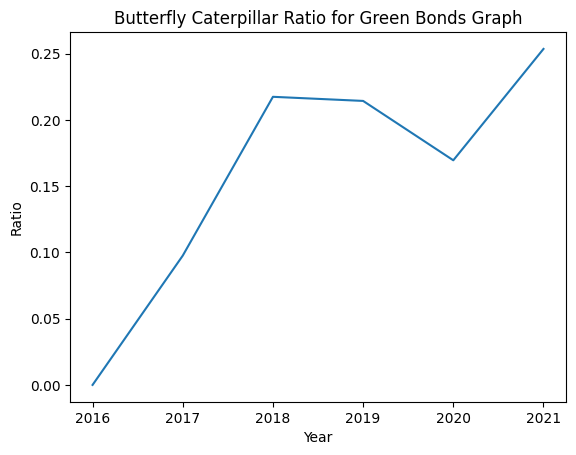

In [61]:
plt.plot(bonds_time.Year, bonds_time.Ratio)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Butterfly Caterpillar Ratio for Green Bonds Graph')

Things to implement temporally: (loop through every year, show how these change)
- number of nodes (remove those without any edges)
- number of edges (weighted)
- number of trianges -> metamorphis coefficient
- change point detection
- any other correlation measures

Node based metrics:
- harmonic, closeness, degree, & eigenvector centralities
- you can show how it changes over time

Clustering:
- find out how to cluster bipartite graphs
- change point detection

### Fossil Fuel Subsidies

##### Data Import
Note that we need to keep values titled "NA" because that's Namibia's ISO2 code. Also, Kosovo doesn't have an ISO3 so we can't use that.

In [24]:
subsidy = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
subsidy.head(3)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023,F2024,F2025
ObjectId,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",US Dollars,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Electricity,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTET,Explicit; Electricity,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.083287,0.375834,0.075661,0.252216,0.247982,0.270226,0.271118,0.245831


In [25]:
country_nodes = subsidy.ISO2.unique()
policy_nodes = subsidy.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

Number of Countries: 197
Number of Subsidies: 21


Another question would be how do we create groups of subsidies. We'll call the fossil fuel subsidy bi-partite graph S.

In [26]:
S = nx.Graph()
S.add_nodes_from(country_nodes, bipartite=0)
S.add_nodes_from(policy_nodes, bipartite=1)

Note that the following countries do not have the Petroleum field. We'll simply not draw edges.

In [27]:
full = set(subsidy[subsidy.ISO2 == "AF"].CTS_Name)
subsidy_sub = subsidy[subsidy.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = subsidy_sub[subsidy_sub.ISO2 == country]
    if len(subset) < 21:
        print(country, len(subset))
        partial = set(subsidy[subsidy.ISO2 == country].CTS_Name)
        print(full - partial)

AI 20
{'Implicit; Petroleum'}
MH 20
{'Implicit; Petroleum'}
PW 20
{'Implicit; Petroleum'}
SM 20
{'Implicit; Petroleum'}
TV 20
{'Implicit; Petroleum'}


Loop through every country/policy combination and add an edge if the value for specified year was greater than 0.

In [31]:
df_temp = subsidy[subsidy.Unit == "Percent of GDP"]
df_temp.set_index(["ISO2", "CTS_Code"], inplace = True)
dict = {}

for year in subsidy.columns[9:]:
    edge_list = []
    for country in country_nodes:
        subset = df_temp.loc[country]
        for policy_code in subset.index:
            weight = subset.loc[policy_code][year]
            if weight > 0:
                edge = (country, policy_code, weight)
                edge_list.append(edge)
    dict[int(year[1:])] = edge_list

S.add_weighted_edges_from(edge_list)

In [32]:
print("Number of Edges:", S.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 3118
Number of Possible Edges: 4137


##### Analysis

In [37]:
results = []
years = [int(year[1:]) for year in subsidy.columns[9:]]
for year in years:
    S.remove_edges_from(S.edges)
    S.add_weighted_edges_from(dict[year])
    results.append({"Year": year, "Countries": country_count(S, country_nodes), "Edges": S.number_of_edges(), "Butterflies": butterflies(S),\
                    "Caterpillars": caterpillars(S), "Ratio": 4 * butterflies(S) / caterpillars(S)})
subsidy_time = pd.DataFrame(results)

In [62]:
subsidy_time

,Year,Countries,Edges,Butterflies,Caterpillars,Ratio
0,2015,188,2625,1042378,5239483,0.795787
1,2016,188,2638,1047575,5273580,0.794584
2,2017,189,2704,1115783,5582115,0.799541
3,2018,190,2825,1268430,6215032,0.816363
4,2019,191,3034,1584275,7442802,0.851440
5,2020,190,2859,1320783,6413289,0.823779
6,2021,191,2870,1336347,6467542,0.826495
7,2022,191,2877,1341583,6488692,0.827028
8,2023,191,2915,1399480,6711951,0.834023
9,2024,191,2914,1404496,6723779,0.835540


Text(0.5, 1.0, 'Butterfly Caterpillar Ratio for Fossil Fuel Subsidy Graph')

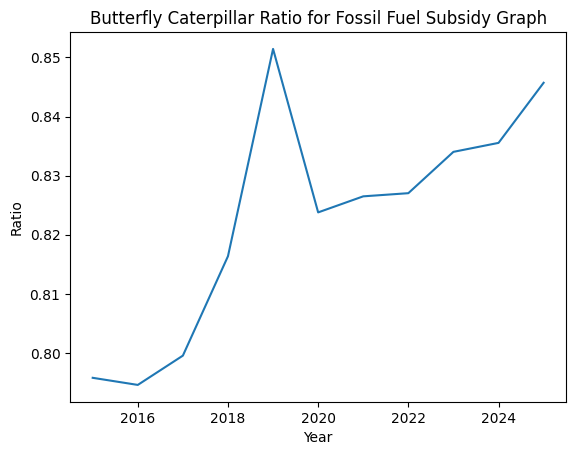

In [43]:
plt.plot(subsidy_time.Year, subsidy_time.Ratio)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Butterfly Caterpillar Ratio for Fossil Fuel Subsidy Graph')

### Environmental Taxes

First lets load in the data and take a quick peak.  The final table is a table about how many measures each country implements.

In [12]:
taxes = pd.read_csv("input/policy/Environmental_Taxes.csv", index_col=0, keep_default_na=False, na_values="")

num_countries = len(taxes["Country"].unique())
print(f"There are {num_countries} unique countries that are implementing environmental taxes")
print("Each country typically reports 10 different measures, but there are a few that report less than 10 measures")

taxes.Country.value_counts().value_counts()

There are 124 unique countries that are implementing environmental taxes
Each country typically reports 10 different measures, but there are a few that report less than 10 measures


10    118
8       3
6       1
5       1
4       1
Name: Country, dtype: int64

In [105]:
country_nodes = taxes.ISO2.unique()
policy_nodes = taxes.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

T = nx.Graph()
T.add_nodes_from(country_nodes, bipartite=0)
T.add_nodes_from(policy_nodes, bipartite=1)

Number of Countries: 124
Number of Subsidies: 5


In [106]:
edges = []
year = "F2018"
taxes_sub = taxes[taxes.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = taxes_sub[taxes_sub.ISO2 == country]
    for policy in policy_nodes:
        weight = subset[subset.CTS_Code == policy][year].values
        if weight > 0:
            edge = (country, policy, weight[0])
            edges.append(edge)

/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_95744/2768913331.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight > 0:


In [107]:
T.add_weighted_edges_from(edges)
print("Number of Edges:", T.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 415
Number of Possible Edges: 620


### Environmental Protection Expenditures

In [108]:
expenditures = pd.read_csv("input/policy/Environmental_Protection_Expenditures.csv", index_col=0, keep_default_na=False, na_values="")
expenditures.head(5)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F1995,...,F2012,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021
ObjectId,,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on biodiversity & landscape protec...,"International Monetary Fund (IMF), Statistics ...",GENB_G14,Expenditure on Biodiversity & Landscape Protec...,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,NaN,NaN,NaN,NaN,1.243785e+08,1.258269e+09,NaN,NaN,NaN,NaN
2,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on biodiversity & landscape protec...,"International Monetary Fund (IMF), Statistics ...",GENB_G14,Expenditure on Biodiversity & Landscape Protec...,"Government and Public Sector Finance, Expendit...",Percent of GDP,NaN,...,NaN,NaN,NaN,NaN,9.433491e-03,9.134202e-02,NaN,NaN,NaN,NaN
3,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environment protection,"International Monetary Fund (IMF), Statistics ...",GEN_G14,Environmental Protection Expenditures,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,2.846995e+09,3.344665e+09,2.204964e+09,1.122601e+09,1.702933e+09,2.377937e+09,NaN,NaN,NaN,NaN
4,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environment protection,"International Monetary Fund (IMF), Statistics ...",GEN_G14,Environmental Protection Expenditures,"Government and Public Sector Finance, Expendit...",Percent of GDP,NaN,...,2.754469e-01,2.994793e-01,1.863813e-01,9.152359e-02,1.291590e-01,1.726226e-01,NaN,NaN,NaN,NaN
5,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environmental protection n.e.c.,"International Monetary Fund (IMF), Statistics ...",GENO_G14,Expenditure on Environmental Protection Not El...,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,NaN,NaN,NaN,NaN,9.669078e+07,8.846917e+07,NaN,NaN,NaN,NaN


In [109]:
country_nodes = expenditures.ISO2.unique()
policy_nodes = expenditures.CTS_Code.unique()
print("Number of countries:", len(country_nodes))
print("Number of expenditures:", len(policy_nodes))

E = nx.Graph()
E.add_nodes_from(country_nodes, bipartite=0)
E.add_nodes_from(policy_nodes, bipartite=1)

Number of countries: 129
Number of expenditures: 7


In [110]:
edges = []
year = "F2018"

exp_sub = expenditures[expenditures.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = exp_sub[exp_sub.ISO2 == country]
    for policy in policy_nodes:
        weight = subset[subset.CTS_Code == policy][year].values
        if weight.size > 0 and weight > 0:
            edge = (country, policy, weight[0])
            edges.append(edge)

In [111]:
print("Number of possible edges:", len(country_nodes) * len(policy_nodes))
print("Number of edges:", len(edges))

Number of possible edges: 903
Number of edges: 495


### Generator for Arbitrary Dataset
Disregard for now. Every dataset requires different pre-processing.

In [25]:
frame = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
country_nodes = frame.ISO2.unique()
policy_nodes = frame.CTS_Code.unique()
G = nx.Graph()
G.add_nodes_from(country_nodes, bipartite=0)
G.add_nodes_from(policy_nodes, bipartite=1)
years = [int(col[1:]) for col in frame.columns if len(col) == 5 and col[0] == 'F' and col[1:].isdigit()]
index = [i for i in range(len(frame.columns)) if frame.columns[i] == 'F' + str(years[0])][0]

### Analysis

In [ ]:
for comp in nx.connected_components(B):
    print(comp)

In [ ]:
G = nx.Graph()
G.add_nodes_from(country_nodes, bipartite=0)
G.add_nodes_from(policy_nodes, bipartite=1)

### IP

In [2]:
from helper import CCNA, IP
print("Running temporal graph...")
obj = CCNA("Environmental_Protection_Expenditures")
print("Temporal Metrics:\n", obj.temporal_metrics())

Running temporal graph...
Temporal Metrics:
     Year  Countries  Edges  Butterflies  Caterpillars     Ratio
0   1995         30    128         2329         11253  0.206967
1   1996         31    132         2592         12216  0.212181
2   1997         31    131         2505         11929  0.209992
3   1998         31    132         2592         12216  0.212181
4   1999         33    133         2481         12078  0.205415
5   2000         38    144         2803         13945  0.201004
6   2001         45    209         6681         31343  0.213158
7   2002         62    230         7271         36119  0.201307
8   2003         61    228         7130         35468  0.201026
9   2004         63    236         7803         38362  0.203404
10  2005         66    251         8974         43766  0.205045
11  2006         69    256         8968         44725  0.200514
12  2007         69    262         9794         47742  0.205144
13  2008         79    286        10795         55031  0.19

In [3]:
print("Building directed graph...")
G = obj.influence_graph()
metrics = {"Nodes": G.number_of_nodes(), "Edges": G.number_of_edges(), "Clustering": nx.average_clustering(G),\
           "Countries": len(obj.countries), "Policies": len(obj.policies)}
print("Directed Graph Values:\n", metrics)

Building directed graph...
Directed Graph Values:
 {'Nodes': 128, 'Edges': 8686, 'Clustering': 0.5832986130944742, 'Countries': 128, 'Policies': 7}


In [4]:
# Initializing IP values
print("Loading graph into IP algorithm...")
ip_obj = IP(G)
print("IP algorithm initialized.")

Loading graph into IP algorithm...
IP algorithm initialized.


In [18]:
# Computing influence and passivity
M = 20
print("Running", M, "iterations...")
ip_obj.iterate(M)
influence = ip_obj.influence[M - 1]
passivity = ip_obj.passivity[M - 1]

Running 20 iterations...


In [19]:
pd.DataFrame({"Country": ip_obj.countries, "Influence": influence, "Passivity": passivity}).sort_values('Influence', ascending=False).head(10)

,Country,Influence,Passivity
31,KW,0.018743,0.007819
42,IR,0.016657,0.007819
107,OM,0.014529,0.007819
28,BI,0.013079,0.007770
6,BD,0.013011,0.007819
66,DE,0.012502,0.007808
7,KE,0.012423,0.007950
29,EE,0.012332,0.007806
10,SI,0.012248,0.007827
62,AT,0.012248,0.007827


/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_65778/3167368643.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(y_i))
/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_65778/3167368643.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(y_p))


Text(0.5, 1.0, 'Convergence of IP Algorithm')

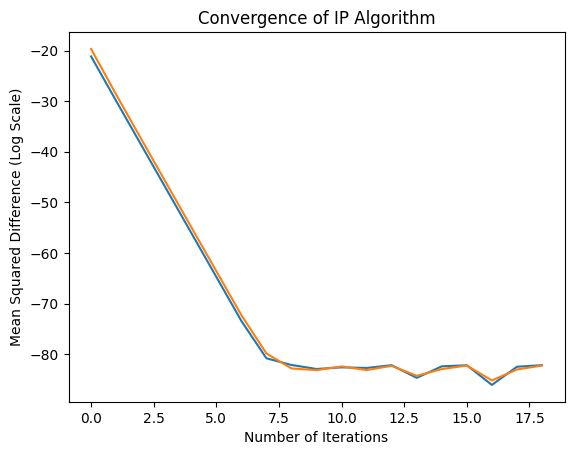

In [22]:
I_diffs = []
P_diffs = []
for m in range(M):
    I_diff = ((ip_obj.influence[m] - influence)**2).mean()
    P_diff = ((ip_obj.passivity[m] - passivity)**2).mean()
    I_diffs.append(I_diff)
    P_diffs.append(P_diff)
x = range(M)
y_i = np.array(I_diffs)
y_p = np.array(P_diffs)
plt.plot(x, np.log(y_i))
plt.plot(x, np.log(y_p))
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Difference (Log Scale)")
plt.title("Convergence of IP Algorithm")